In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet
%matplotlib inline

In [2]:
df = pd.read_csv('ENA_Nordeste_2.csv')

In [3]:
df.head()

,Dia,ENA_chuva,ENA_obs,Season
0,01/01/2007,16.569619,15241,summer
1,01/02/2007,8.415050,15569,summer
2,01/03/2007,8.781204,16651,summer
3,01/04/2007,18.405242,16555,summer
4,01/05/2007,9.523851,16481,summer


In [4]:
df['Dia'] = pd.to_datetime(df['Dia'])
df = df.set_index('Dia')
df.head()

,ENA_chuva,ENA_obs,Season
Dia,,,
2007-01-01,16.569619,15241,summer
2007-01-02,8.415050,15569,summer
2007-01-03,8.781204,16651,summer
2007-01-04,18.405242,16555,summer
2007-01-05,9.523851,16481,summer


In [5]:
# label encoding the data 
from sklearn.preprocessing import LabelEncoder 

le = LabelEncoder() 

df['Season']= le.fit_transform(df['Season']) 


In [6]:
daily_df = df.resample('D').mean()
d_df = daily_df.reset_index().dropna()

d_df['date_index'] = d_df['Dia']
d_df['date_index'] = pd.to_datetime(d_df['date_index'])
d_df = d_df.set_index('date_index')
d_df=d_df[['Dia','ENA_obs','ENA_chuva','Season']]

In [7]:
d_df.head()

,Dia,ENA_obs,ENA_chuva,Season
date_index,,,,
2007-01-01,2007-01-01,15241,16.569619,2
2007-01-02,2007-01-02,15569,8.415050,2
2007-01-03,2007-01-03,16651,8.781204,2
2007-01-04,2007-01-04,16555,18.405242,2
2007-01-05,2007-01-05,16481,9.523851,2


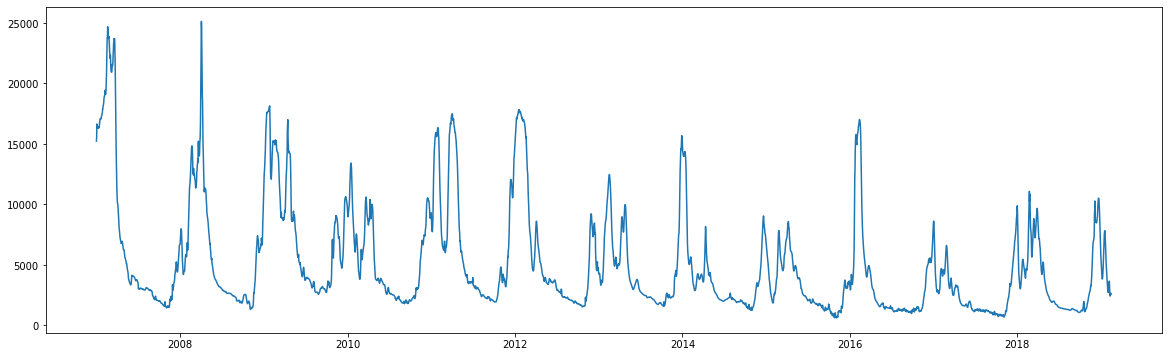

In [8]:
d_df.columns = ['ds', 'y', 'ENA_chuva','Season']

fig = plt.figure(facecolor='w', figsize=(20, 6))
plt.plot(d_df.ds, d_df.y)

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

d_df[['y', 'ENA_chuva']] = scaler.fit_transform(d_df[['y', 'ENA_chuva']])

In [14]:
d_df['cap']=4.5
d_df.head()

,ds,y,ENA_chuva,Season,cap
date_index,,,,,
2007-01-01,2007-01-01,2.266679,0.695128,2,4.5
2007-01-02,2007-01-02,2.340220,0.047486,2,4.5
2007-01-03,2007-01-03,2.582818,0.076566,2,4.5
2007-01-04,2007-01-04,2.561293,0.840914,2,4.5
2007-01-05,2007-01-05,2.544702,0.135548,2,4.5


In [15]:
prev = pd.read_excel('PrevisãodaENAChuva.xls')
prev.head()

,Unnamed: 0,Sul,Sudeste Hoje,Nordeste Hoje,Norte Hoje,SIN Hoje,Sul Ontem,Sudeste Ontem,Nordeste Ontem,Norte Ontem,SIN Ontem,Sul 5 a 7 dias,Sudeste Ontem.1,Nordeste Ontem.1,Norte Ontem.1,SIN Ontem.1
0,1,2.579054,27.028201,37.864500,15.092090,82.563844,2.707530,24.260855,36.025004,18.806752,81.800141,NaN,NaN,NaN,NaN,0
1,2,4.066837,21.913002,22.478327,9.150846,57.609012,4.550282,21.948399,23.126165,13.374528,62.999374,NaN,NaN,NaN,NaN,0
2,3,3.346850,27.066926,12.934498,8.977152,52.325426,1.767289,9.116620,6.319009,4.673346,21.876264,NaN,NaN,NaN,NaN,0
3,4,3.341528,37.208709,12.089114,9.929386,62.568736,3.513069,34.225943,9.989673,15.306207,63.034892,NaN,NaN,NaN,NaN,0
4,5,1.725934,27.625197,10.925446,9.735029,50.011607,3.246969,21.088873,6.788815,10.530483,41.655140,NaN,NaN,NaN,NaN,0


In [16]:
future_range = pd.date_range('2019-02-15', periods=16, freq='D')
future_ena_df = pd.DataFrame({ 'future_date': future_range, 'future_ena' : prev['Nordeste Hoje']})
future_ena_df['future_date'] = pd.to_datetime(future_ena_df['future_date'])
future_ena_df = future_ena_df.set_index('future_date')
future_ena_df[['future_ena']] = scaler.fit_transform(future_ena_df[['future_ena']])

In [17]:
future_ena_df

,future_ena
future_date,
2019-02-15,0.297365
2019-02-16,-0.513000
2019-02-17,-1.015659
2019-02-18,-1.060184
2019-02-19,-1.121472
2019-02-20,-1.495974
2019-02-21,-0.668263
2019-02-22,-0.012943
2019-02-23,0.034256


In [18]:
def ena_forecast(ds):
    date = (pd.to_datetime(ds)).date()
    
    if d_df[date:].empty:
        return future_ena_df[date:]['future_ena'].values[0]
    else:
        return (d_df[date:]['ENA_chuva']).values[0]
    
    return 0

In [104]:
# Python
model = Prophet(growth='logistic', weekly_seasonality=False, daily_seasonality=False, yearly_seasonality = False, seasonality_mode = 'additive', seasonality_prior_scale = 15, 
                changepoint_prior_scale=.005
                )
model.add_seasonality(name='daily', fourier_order = 25, period=1, prior_scale=25, mode='multiplicative')
#model.add_seasonality(name='monthly', fourier_order = 10, period=91.5, prior_scale=15, mode='additive')
model.add_seasonality(name='yearly', fourier_order = 10, period=365.25, prior_scale=15, mode='multiplicative')
model.add_regressor('ENA_chuva')
model.add_regressor('Season')
model.fit(d_df)

In [105]:
future = model.make_future_dataframe(periods=16, freq='D')
future['ENA_chuva'] = future['ds'].apply(ena_forecast)
future['Season'] = future['ds'].apply(ena_forecast)
future['cap']= 4.5
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(15)

,ds,yhat,yhat_lower,yhat_upper
4429,2019-02-16,0.168556,-0.646067,1.033758
4430,2019-02-17,0.136362,-0.757355,1.029183
4431,2019-02-18,0.132953,-0.701020,0.996653
4432,2019-02-19,0.128165,-0.699039,1.030182
4433,2019-02-20,0.103173,-0.768143,0.888128
4434,2019-02-21,0.154216,-0.674057,0.976342
4435,2019-02-22,0.194018,-0.642955,1.049457
4436,2019-02-23,0.194928,-0.656287,1.028868
4437,2019-02-24,0.216249,-0.618561,1.121911
4438,2019-02-25,0.147308,-0.672248,1.067890


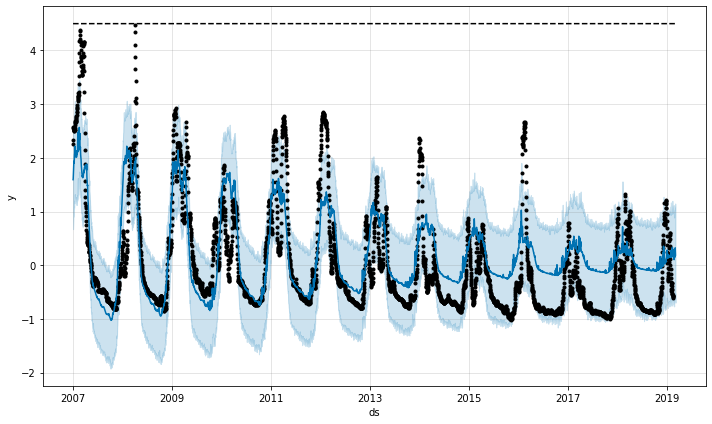

In [106]:
fig1 = model.plot(forecast)

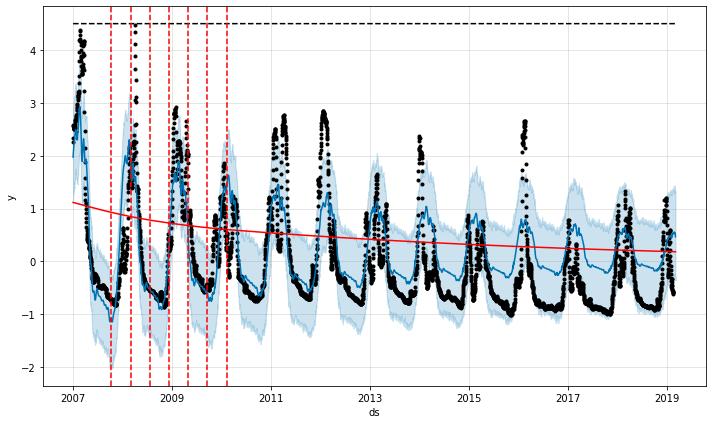

In [99]:
from fbprophet.plot import add_changepoints_to_plot
fig3 = model.plot(forecast)
a = add_changepoints_to_plot(fig3.gca(), model, forecast)

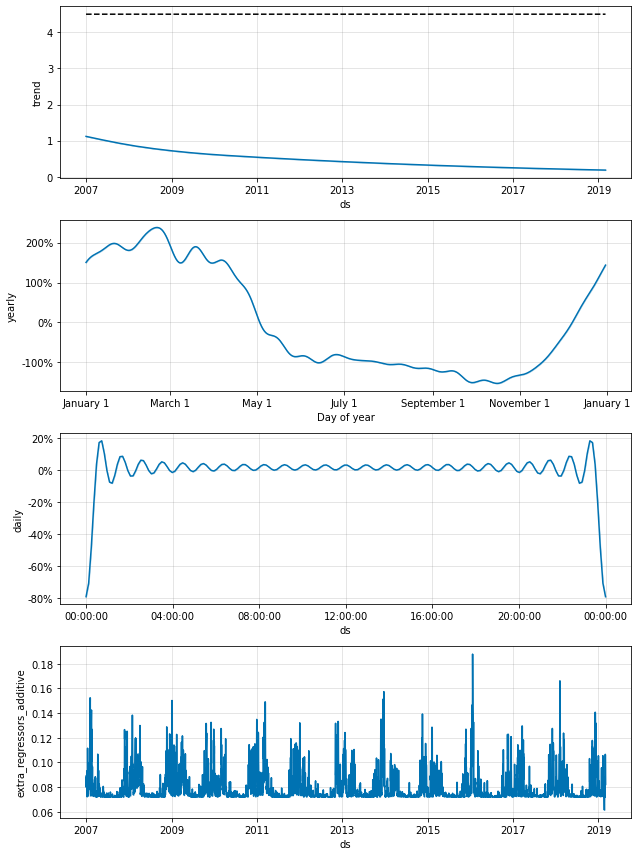

In [100]:
fig2 = model.plot_components(forecast)

In [20]:
forecast

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,ENA_chuva,ENA_chuva_lower,ENA_chuva_upper,...,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2007-01-01,8372.142033,15000,4382.746260,11901.681369,8372.142033,8372.142033,133.963366,133.963366,133.963366,...,-3728.558259,-3728.558259,-3728.558259,3587.975753,3587.975753,3587.975753,0.0,0.0,0.0,8231.559526
1,2007-01-02,8369.342721,15000,6619.915658,13712.097484,8369.342721,8369.342721,9.151390,9.151390,9.151390,...,-1761.564965,-1761.564965,-1761.564965,3673.217064,3673.217064,3673.217064,0.0,0.0,0.0,10280.994819
2,2007-01-03,8366.543163,15000,6672.963998,13916.222462,8366.543163,8366.543163,14.755661,14.755661,14.755661,...,-1849.886321,-1849.886321,-1849.886321,3755.590520,3755.590520,3755.590520,0.0,0.0,0.0,10272.247362
3,2007-01-04,8363.743360,15000,4477.503858,11658.750679,8363.743360,8363.743360,162.059004,162.059004,162.059004,...,-4171.335737,-4171.335737,-4171.335737,3835.025190,3835.025190,3835.025190,0.0,0.0,0.0,8027.432813
4,2007-01-05,8360.943313,15000,6658.187762,13867.854902,8360.943313,8360.943313,26.122453,26.122453,26.122453,...,-2029.023013,-2029.023013,-2029.023013,3911.452733,3911.452733,3911.452733,0.0,0.0,0.0,10243.373032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4439,2019-02-26,2658.259953,15000,-8211.460126,-974.814724,2658.259953,2658.259953,609.498425,609.498425,609.498425,...,-11222.825292,-11222.825292,-11222.825292,3930.840073,3930.840073,3930.840073,0.0,0.0,0.0,-4633.725265
4440,2019-02-27,2657.449313,15000,-10885.134071,-3601.365748,2657.449313,2657.449313,782.705559,782.705559,782.705559,...,-13952.509437,-13952.509437,-13952.509437,3898.270096,3898.270096,3898.270096,0.0,0.0,0.0,-7396.790028
4441,2019-02-28,2656.638867,15000,-14839.081373,-7860.852339,2656.638867,2656.638867,1032.970804,1032.970804,1032.970804,...,-17896.602598,-17896.602598,-17896.602598,3866.706903,3866.706903,3866.706903,0.0,0.0,0.0,-11373.256828
4442,2019-03-01,2655.828615,15000,-9590.965098,-2032.760594,2655.828615,2655.828615,682.066977,682.066977,682.066977,...,-12366.480417,-12366.480417,-12366.480417,3836.212334,3836.212334,3836.212334,0.0,0.0,0.0,-5874.439468


In [124]:
forecast['yhat'][-29:]

4415    4410.407499
4416    4338.413721
4417    4542.522593
4418    4662.353300
4419    4947.301472
4420    5507.892051
4421    5320.996735
4422    4878.137833
4423    5274.276585
4424    4898.085683
4425    4344.130716
4426    4387.451152
4427    5037.041773
4428    5831.848418
4429    5280.667899
4430    4937.774818
4431    4911.200103
4432    4865.298915
4433    4588.405810
4434    5149.246471
4435    5588.443960
4436    5608.264454
4437    5863.780871
4438    5117.022583
4439    6106.312364
4440    6473.340915
4441    7011.694429
4442    6091.465622
4443    5436.636457
Name: yhat, dtype: float64

In [20]:
from fbprophet.diagnostics import performance_metrics,cross_validation
df_cv = cross_validation(model, horizon='16 days')
df_p = performance_metrics(df_cv)
df_p.head(5)

INFO:fbprophet:Making 506 forecasts with cutoffs between 2008-01-07 00:00:00 and 2019-01-29 00:00:00


KeyboardInterrupt: 

In [ ]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')